# Reduced Likelihood for Linear Regression

This notebook demonstrates CoFI's `ReducedLikelihood` class for handling unknown data covariance in inverse problems.

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_reduced_likelihood.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

## Problem Setup

We fit a polynomial curve to noisy data:
$$y(x) = \sum_{n=0}^N m_n x^n$$

The true model is: $y = -6 - 5x + 2x^2 + x^3$

In matrix form, the forward problem is $\mathbf{d} = \mathbf{G}\mathbf{m}$, where $\mathbf{G}$ is the Vandermonde matrix.

---
## 1. Import Modules

In [23]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cofi import BaseProblem, InversionOptions, Inversion
from cofi.utils import QuadraticReg, ReducedLikelihood

np.random.seed(42)

---
## 2. Define the Problem

We compute $y(x)$ for multiple $x$-values simultaneously using the forward operator:

$$ \mathbf{d} = \mathbf{G}\mathbf{m} $$

where $\mathbf{G}$ is the Vandermonde (basis) matrix and $\mathbf{m}$ are the polynomial coefficients.

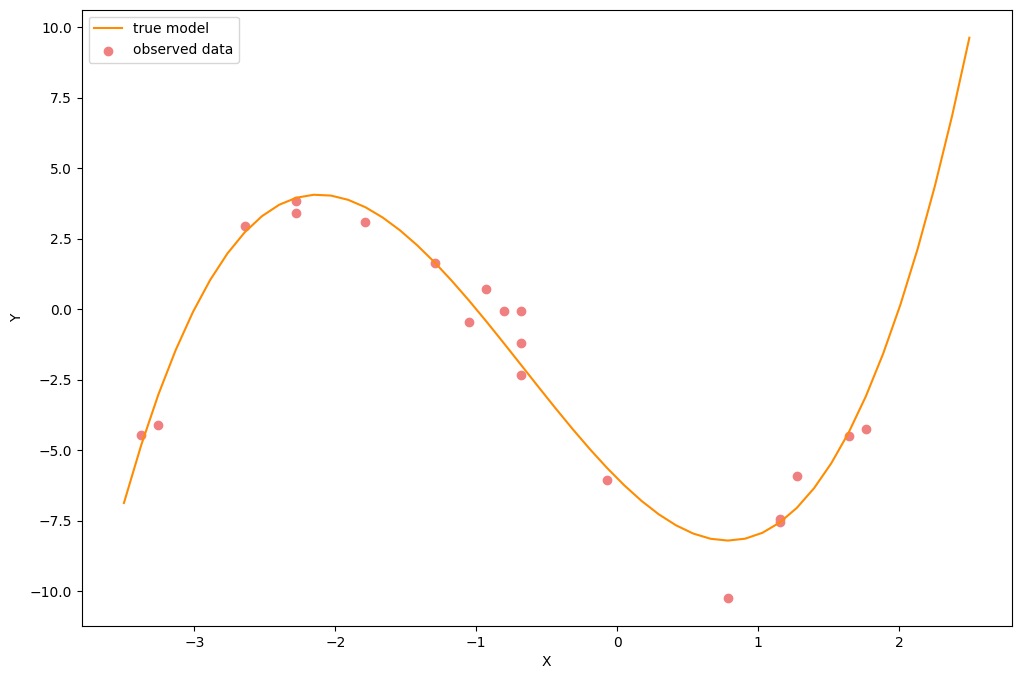

In [25]:
# generate data with random Gaussian noise
def basis_func(x):
    return np.array([x**i for i in range(4)]).T                           # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m
sample_size = 20                                                        # N
sigma = 1.0                                                             # noise standard deviation
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
def forward_func(m):
    return basis_func(x) @ m                                              # m -> y_synthetic
y_observed = forward_func(_m_true) + np.random.normal(0, sigma, sample_size)  # d

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange", label="true model")
plt.scatter(x, y_observed, color="lightcoral", label="observed data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend();

---
## 3. Reduced Likelihood Theory

In many inverse problems, the data covariance $C_d$ is unknown and must be estimated alongside the model parameters. The **reduced likelihood** approach marginalizes over the unknown covariance parameters.

### Standard Gaussian Likelihood

The standard log-likelihood for Gaussian errors is:

$$\log p(\mathbf{d}|\mathbf{m}, C_d) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} - \frac{1}{2}\log|C_d| - \frac{n}{2}\log(2\pi)$$

where $\mathbf{r} = \mathbf{d} - \mathbf{G}\mathbf{m}$ is the residual vector.

### Reduced Likelihood Cases

CoFI's `ReducedLikelihood` class supports five cases for estimating $C_d$:

| Case | Covariance Model | Parameters Estimated | Degrees of Freedom |
|------|------------------|---------------------|-------------------|
| `'none'` | $C_d$ fixed (known) | 0 | - |
| `'scaled'` | $C_d = a \cdot C_{d,ref}$ | 1 (scale factor $a$) | Well-posed |
| `'spherical'` | $C_d = s \cdot I$ | 1 (variance $s$) | Well-posed |
| `'diag'` | $C_d = \text{diag}(\sigma_1^2, \ldots, \sigma_n^2)$ | $n$ (one per data point) | Ill-posed |
| `'full'` | $C_d = \mathbf{r}\mathbf{r}^T$ | Outer product | Rank-1 approximation |

### Maximum Likelihood Estimates

For each case, the ML estimate of the covariance is:

- **'scaled'**: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$
- **'spherical'**: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$
- **'diag'**: $\hat{\sigma}_i^2 = r_i^2$
- **'full'**: $\hat{C}_d = \mathbf{r}\mathbf{r}^T$

In [26]:
# Define known covariance matrices for testing
# These are the "true" covariance matrices we'll use to assess each case

# Cases 1-3 use the original data (y_observed) with simple Gaussian noise
# Case 1: 'none' - We know the exact covariance (sigma^2 * I)
Cd_true_none = np.eye(sample_size) * (sigma**2)

# Case 2: 'scaled' - We have a reference covariance (identity) that will be scaled
Cd_ref_scaled = np.eye(sample_size)
# The true covariance is actually sigma^2 * I, so scale factor should be sigma^2

# Case 3: 'spherical' - True covariance is sigma^2 * I (spherical with s = sigma^2)
Cd_true_spherical = np.eye(sample_size) * (sigma**2)

# Cases 4-5: Generate NEW datasets with specific covariance structures
# Case 4: 'diag' - Create a diagonal covariance with varying variances
np.random.seed(42)
diag_variances = np.random.uniform(0.5, 1.5, sample_size)
Cd_true_diag = np.diag(diag_variances)

# Generate data with diagonal covariance (independent but different variances)
noise_diag = np.random.randn(sample_size) * np.sqrt(diag_variances)
y_observed_diag = forward_func(_m_true) + noise_diag

# Case 5: 'full' - Create a full covariance matrix
A = np.random.randn(sample_size, sample_size)
Cd_true_full = A @ A.T / sample_size + 0.1 * np.eye(sample_size)  # Ensure positive definite

# Generate data with full covariance (correlated noise)
noise_full = np.random.multivariate_normal(np.zeros(sample_size), Cd_true_full)
y_observed_full = forward_func(_m_true) + noise_full

print(f"True covariance matrices and datasets defined:")
print(f"  - none:      Uses y_observed, Cd shape {Cd_true_none.shape}, variance {sigma**2}")
print(f"  - scaled:    Uses y_observed, Cd_ref shape {Cd_ref_scaled.shape}")
print(f"  - spherical: Uses y_observed, Cd shape {Cd_true_spherical.shape}, variance {sigma**2}")
print(f"  - diag:      Uses y_observed_diag, Cd shape {Cd_true_diag.shape}, varying variances")
print(f"               Variance range: [{diag_variances.min():.3f}, {diag_variances.max():.3f}]")
print(f"  - full:      Uses y_observed_full, Cd shape {Cd_true_full.shape}, full covariance")
print(f"               Condition number: {np.linalg.cond(Cd_true_full):.2f}")

True covariance matrices and datasets defined:
  - none:      Uses y_observed, Cd shape (20, 20), variance 1.0
  - scaled:    Uses y_observed, Cd_ref shape (20, 20)
  - spherical: Uses y_observed, Cd shape (20, 20), variance 1.0
  - diag:      Uses y_observed_diag, Cd shape (20, 20), varying variances
               Variance range: [0.521, 1.470]
  - full:      Uses y_observed_full, Cd shape (20, 20), full covariance
               Condition number: 31.36


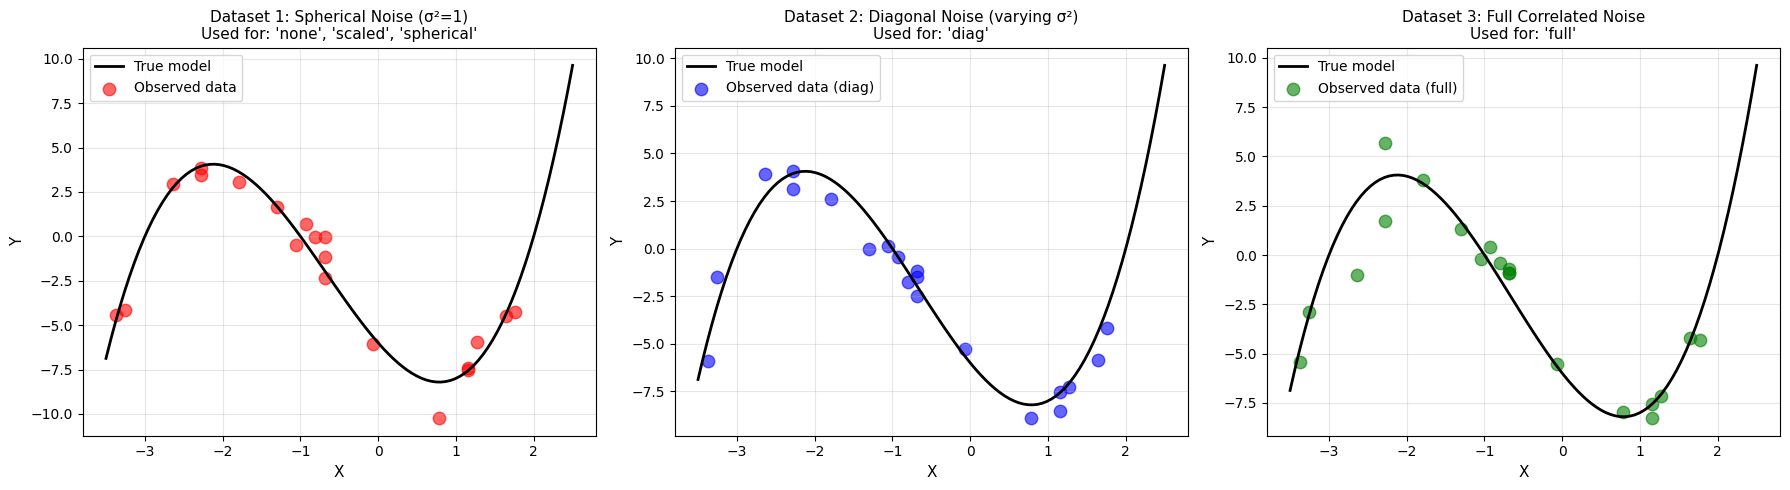

In [27]:
# Visualize the three different datasets
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Original (cases none, scaled, spherical)
axes[0].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[0].scatter(x, y_observed, color='red', s=80, alpha=0.6, label='Observed data')
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title("Dataset 1: Spherical Noise (σ²=1)\nUsed for: 'none', 'scaled', 'spherical'", fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Dataset 2: Diagonal covariance (case diag)
axes[1].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[1].scatter(x, y_observed_diag, color='blue', s=80, alpha=0.6, label='Observed data (diag)')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title("Dataset 2: Diagonal Noise (varying σ²)\nUsed for: 'diag'", fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Dataset 3: Full covariance (case full)
axes[2].plot(_x_plot, _y_plot, 'k-', linewidth=2, label='True model')
axes[2].scatter(x, y_observed_full, color='green', s=80, alpha=0.6, label='Observed data (full)')
axes[2].set_xlabel('X', fontsize=11)
axes[2].set_ylabel('Y', fontsize=11)
axes[2].set_title("Dataset 3: Full Correlated Noise\nUsed for: 'full'", fontsize=11)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Case 1: `'none'` - Fixed Known Covariance

When the data covariance is known exactly, we use the standard Gaussian likelihood:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{1}{2}\mathbf{r}^T C_d^{-1} \mathbf{r} + \text{const}$$

**Gradient:** $\nabla_\mathbf{m} \log p = \mathbf{G}^T C_d^{-1} \mathbf{r}$

**Hessian:** $\mathbf{H} = -\mathbf{G}^T C_d^{-1} \mathbf{G}$

In [28]:
# Create ReducedLikelihood with case='none'
lik_none = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_true_none,
    case='none'
)

# Define inverse problem
inv_problem_rl_none = BaseProblem()
inv_problem_rl_none.name = "Polynomial Regression - ReducedLikelihood (none)"
inv_problem_rl_none.set_objective(lambda m: -lik_none.log_likelihood(m))
inv_problem_rl_none.set_gradient(lambda m: -lik_none.gradient(m))
inv_problem_rl_none.set_hessian(lambda m: -lik_none.hessian(m))
inv_problem_rl_none.set_initial_model(np.zeros(4))

# Set up inversion
inv_options_rl_none = InversionOptions()
inv_options_rl_none.set_tool("scipy.optimize.minimize")
inv_options_rl_none.set_params(method="Newton-CG")

# Run inversion
inv_rl_none = Inversion(inv_problem_rl_none, inv_options_rl_none)
result_rl_none = inv_rl_none.run()

print(f"Success: {result_rl_none.success}")
print(f"Estimated model: {result_rl_none.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_none.model - _m_true):.6f}")

# Verify the ML covariance equals the input covariance
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
print(f"\nCovariance check:")
print(f"  ML covariance matches input: {np.allclose(Cd_ml_none, Cd_true_none)}")

Success: True
Estimated model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.348662

Covariance check:
  ML covariance matches input: True


### Case 2: `'scaled'` - Scaled Reference Covariance

The covariance is a scaled version of a known reference: $C_d = a \cdot C_{d,ref}$

The reduced log-likelihood (after marginalizing over $a$) is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}\right) + \text{const}$$

The ML estimate of the scale factor is: $\hat{a} = \frac{1}{n}\mathbf{r}^T C_{d,ref}^{-1} \mathbf{r}$

In [29]:
# Create ReducedLikelihood with case='scaled'
lik_scaled = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    Cd_ref=Cd_ref_scaled,
    case='scaled'
)

# Define inverse problem
inv_problem_rl_scaled = BaseProblem()
inv_problem_rl_scaled.set_objective(lambda m: -lik_scaled.log_likelihood(m))
inv_problem_rl_scaled.set_gradient(lambda m: -lik_scaled.gradient(m))
inv_problem_rl_scaled.set_hessian(lambda m: -lik_scaled.hessian(m))
inv_problem_rl_scaled.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_scaled = InversionOptions()
inv_options_rl_scaled.set_tool("scipy.optimize.minimize")
inv_options_rl_scaled.set_params(method="Newton-CG")

inv_rl_scaled = Inversion(inv_problem_rl_scaled, inv_options_rl_scaled)
result_rl_scaled = inv_rl_scaled.run()

print(f"Success: {result_rl_scaled.success}")
print(f"Estimated model: {result_rl_scaled.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_scaled.model - _m_true):.6f}")

# Get estimated covariance and check the scale factor
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
estimated_scale = Cd_ml_scaled[0, 0]
true_scale = sigma**2
print(f"\nEstimated scale factor: {estimated_scale:.4f}")
print(f"True scale factor:      {true_scale:.4f}")
print(f"Scale factor error:     {abs(estimated_scale - true_scale):.4f}")

Success: True
Estimated model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
Error (L2 norm): 0.348662

Estimated scale factor: 0.7481
True scale factor:      1.0000
Scale factor error:     0.2519


### Case 3: `'spherical'` - Spherical Covariance

The covariance is isotropic: $C_d = s \cdot I$ (same variance for all data points)

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right) + \text{const}$$

The ML estimate of the variance is: $\hat{s} = \frac{1}{n}\|\mathbf{r}\|^2$

This is the most common case when noise statistics are unknown but assumed to be uniform.

In [30]:
# Create ReducedLikelihood with case='spherical'
lik_spherical = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    case='spherical'
)

# Define inverse problem
inv_problem_rl_spherical = BaseProblem()
inv_problem_rl_spherical.set_objective(lambda m: -lik_spherical.log_likelihood(m))
inv_problem_rl_spherical.set_gradient(lambda m: -lik_spherical.gradient(m))
inv_problem_rl_spherical.set_hessian(lambda m: -lik_spherical.hessian(m))
inv_problem_rl_spherical.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_spherical = InversionOptions()
inv_options_rl_spherical.set_tool("scipy.optimize.minimize")
inv_options_rl_spherical.set_params(method="Newton-CG")

inv_rl_spherical = Inversion(inv_problem_rl_spherical, inv_options_rl_spherical)
result_rl_spherical = inv_rl_spherical.run()

print(f"Success: {result_rl_spherical.success}")
print(f"Estimated model: {result_rl_spherical.model}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_spherical.model - _m_true):.6f}")

# Get estimated covariance and compare to true spherical covariance
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
estimated_variance = Cd_ml_spherical[0, 0]
true_variance = sigma**2
print(f"\nEstimated variance: {estimated_variance:.4f}")
print(f"True variance:      {true_variance:.4f}")
print(f"Variance error:     {abs(estimated_variance - true_variance):.4f}")
print(f"Covariance is spherical: {np.allclose(np.diag(Cd_ml_spherical), Cd_ml_spherical[0, 0] * np.ones(sample_size))}")

Success: True
Estimated model: [-5.71964359 -5.10903808  1.82553662  0.97472374]
Error (L2 norm): 0.348662

Estimated variance: 0.7481
True variance:      1.0000
Variance error:     0.2519
Covariance is spherical: True


### Case 4: `'diag'` - Diagonal Covariance

Each data point has its own variance: $C_d = \text{diag}(\sigma_1^2, \ldots, \sigma_n^2)$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^{n} \log|r_i| + \text{const}$$

The ML estimates are: $\hat{\sigma}_i^2 = r_i^2$

**Warning:** This case is **ill-posed** because we estimate $n$ variance parameters from $n$ data points. The Hessian becomes singular when residuals approach zero. Strong regularization is required for stable inversion.

In [31]:
# Create ReducedLikelihood with case='diag'
# Uses y_observed_diag (data with diagonal covariance)
lik_diag = ReducedLikelihood(
    data=y_observed_diag,
    forward_func=forward_func,
    G=basis_func(x),
    case='diag'
)

# Create regularization with damping
#n_dims = 4
#my_reg = QuadraticReg(
#    weighting_matrix='damping',
#    model_shape=(n_dims,)
#)

# Define inverse problem WITH REGULARIZATION
# Manually combine likelihood and regularization in each function
inv_problem_rl_diag = BaseProblem()
#inv_problem_rl_diag.set_objective(lambda m: -lik_diag.log_likelihood(m) + my_reg(m))
#inv_problem_rl_diag.set_gradient(lambda m: -lik_diag.gradient(m) + my_reg.gradient(m))
#inv_problem_rl_diag.set_hessian(lambda m: -lik_diag.hessian(m) + my_reg.hessian(m))
inv_problem_rl_diag.set_objective(lambda m: -lik_diag.log_likelihood(m)) 
inv_problem_rl_diag.set_gradient(lambda m: -lik_diag.gradient(m)) 
inv_problem_rl_diag.set_hessian(lambda m: -lik_diag.hessian(m)) 
inv_problem_rl_diag.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_diag = InversionOptions()
inv_options_rl_diag.set_tool("scipy.optimize.minimize")
inv_options_rl_diag.set_params(method="Newton-CG")

inv_rl_diag = Inversion(inv_problem_rl_diag, inv_options_rl_diag)
result_rl_diag = inv_rl_diag.run()

print(f"Success: {result_rl_diag.success}")
print(f"Estimated model: {result_rl_diag.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_diag.model - _m_true):.6f}")

# Compare estimated vs true diagonal covariance
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
estimated_diag_vars = np.diag(Cd_ml_diag)
true_diag_vars = np.diag(Cd_true_diag)

print(f"\nDiagonal variance comparison (first 5 elements):")
print(f"  Estimated: {estimated_diag_vars[:5]}")
print(f"  True:      {true_diag_vars[:5]}")
print(f"  Mean abs error: {np.mean(np.abs(estimated_diag_vars - true_diag_vars)):.4f}")

Success: True
Estimated model: [-5.99872519 -4.94096831  1.72901476  0.89553595]
True model:      [-6 -5  2  1]
Error (L2 norm): 0.296365

Diagonal variance comparison (first 5 elements):
  Estimated: [0.84921755 0.82930462 0.88050711 0.82949233 1.14124695]
  True:      [0.87454012 1.45071431 1.23199394 1.09865848 0.65601864]
  Mean abs error: 0.2748


### Case 5: `'full'` - Full Covariance Matrix

The full covariance matrix is estimated as the outer product of residuals:

$$\hat{C}_d = \mathbf{r}\mathbf{r}^T$$

The reduced log-likelihood is:

$$\log p(\mathbf{d}|\mathbf{m}) = -\frac{n}{2}\log\left(\|\mathbf{r}\|^2\right) + \text{const}$$

Note: This produces a rank-1 covariance estimate. For a single realization, this is mathematically equivalent to the 'spherical' case for the model estimate, but the estimated covariance structure differs.

In [33]:
# Create ReducedLikelihood with case='full'
# Uses y_observed_full (data with full correlated covariance)
lik_full = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    case='full'
)

# Create regularization with damping
n_dims = 4
my_reg = QuadraticReg(
    weighting_matrix='damping',
    model_shape=(n_dims,)
)

# Define inverse problem WITH REGULARIZATION
# Note: ReducedLikelihood does NOT have a reg parameter - you must manually combine
# likelihood and regularization in the objective, gradient, and hessian functions
inv_problem_rl_full = BaseProblem()

# Combine likelihood + regularization: objective = -log_likelihood + regularization
inv_problem_rl_full.set_objective(lambda m: -lik_full.log_likelihood(m) + my_reg(m))
inv_problem_rl_full.set_gradient(lambda m: -lik_full.gradient(m) + my_reg.gradient(m))
inv_problem_rl_full.set_hessian(lambda m: -lik_full.hessian(m) + my_reg.hessian(m))
inv_problem_rl_full.set_initial_model(np.zeros(4))

# Run inversion
inv_options_rl_full = InversionOptions()
inv_options_rl_full.set_tool("scipy.optimize.minimize")
inv_options_rl_full.set_params(method="Newton-CG")

inv_rl_full = Inversion(inv_problem_rl_full, inv_options_rl_full)
result_rl_full = inv_rl_full.run()

print(f"Success: {result_rl_full.success}")
print(f"Estimated model: {result_rl_full.model}")
print(f"True model:      {_m_true}")
print(f"Error (L2 norm): {np.linalg.norm(result_rl_full.model - _m_true):.6f}")

# Compare estimated vs true full covariance
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)
frob_error_full = np.linalg.norm(Cd_ml_full - Cd_true_full, 'fro')
rel_error_full = frob_error_full / np.linalg.norm(Cd_true_full, 'fro')

print(f"\nFull covariance comparison:")
print(f"  Frobenius norm error: {frob_error_full:.4f}")
print(f"  Relative error:       {rel_error_full:.4f}")
print(f"  Is symmetric:         {np.allclose(Cd_ml_full, Cd_ml_full.T)}")

Success: True
Estimated model: [-0.04821298 -0.06879318 -0.07478647  0.0031898 ]
True model:      [-6 -5  2  1]
Error (L2 norm): 8.064672

Full covariance comparison:
  Frobenius norm error: 395.5261
  Relative error:       64.1662
  Is symmetric:         True


#### Comparison of All ReducedLikelihood Cases

Let's compare the fitted curves and model parameters from all five covariance cases.

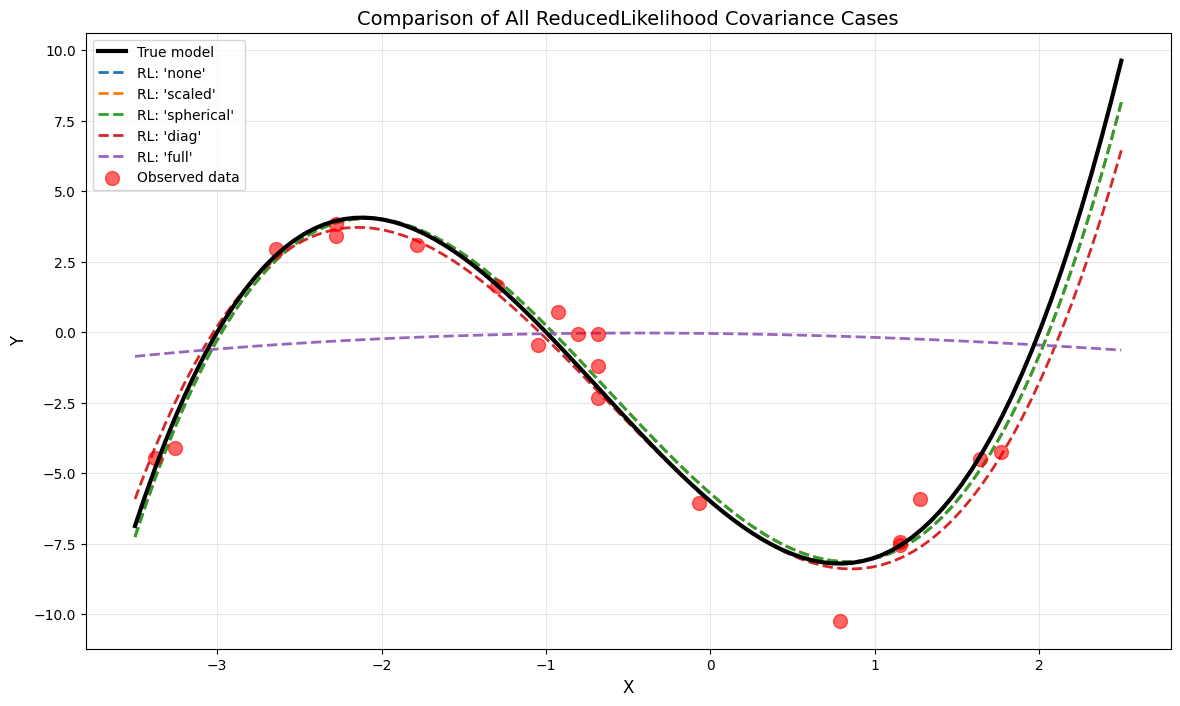

In [34]:
# Plot all fitted curves
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)

plt.figure(figsize=(14, 8))

# True model
plt.plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model', zorder=10)

# Fitted models from ReducedLikelihood
plt.plot(_x_plot, _G_plot @ result_rl_none.model, '--', linewidth=2, label="RL: 'none'")
plt.plot(_x_plot, _G_plot @ result_rl_scaled.model, '--', linewidth=2, label="RL: 'scaled'")
plt.plot(_x_plot, _G_plot @ result_rl_spherical.model, '--', linewidth=2, label="RL: 'spherical'")
plt.plot(_x_plot, _G_plot @ result_rl_diag.model, '--', linewidth=2, label="RL: 'diag'")
plt.plot(_x_plot, _G_plot @ result_rl_full.model, '--', linewidth=2, label="RL: 'full'")

# Data
plt.scatter(x, y_observed, color='red', s=100, alpha=0.6, label='Observed data', zorder=5)

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Comparison of All ReducedLikelihood Covariance Cases', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(alpha=0.3)
plt.show()

In [35]:
# Create comparison table
results_dict = {
    'Case': ['True', "'none'", "'scaled'", "'spherical'", "'diag'", "'full'"],
    'm0': [_m_true[0], result_rl_none.model[0], result_rl_scaled.model[0], 
           result_rl_spherical.model[0], result_rl_diag.model[0], result_rl_full.model[0]],
    'm1': [_m_true[1], result_rl_none.model[1], result_rl_scaled.model[1], 
           result_rl_spherical.model[1], result_rl_diag.model[1], result_rl_full.model[1]],
    'm2': [_m_true[2], result_rl_none.model[2], result_rl_scaled.model[2], 
           result_rl_spherical.model[2], result_rl_diag.model[2], result_rl_full.model[2]],
    'm3': [_m_true[3], result_rl_none.model[3], result_rl_scaled.model[3], 
           result_rl_spherical.model[3], result_rl_diag.model[3], result_rl_full.model[3]],
}

df = pd.DataFrame(results_dict)
print("\\nComparison of Estimated Model Parameters:")
print(df.to_string(index=False))

# Compute errors
print("\\n\\nParameter Errors (L2 norm):")
print(f"  'none':      {np.linalg.norm(result_rl_none.model - _m_true):.6f}")
print(f"  'scaled':    {np.linalg.norm(result_rl_scaled.model - _m_true):.6f}")
print(f"  'spherical': {np.linalg.norm(result_rl_spherical.model - _m_true):.6f}")
print(f"  'diag':      {np.linalg.norm(result_rl_diag.model - _m_true):.6f}")
print(f"  'full':      {np.linalg.norm(result_rl_full.model - _m_true):.6f}")

\nComparison of Estimated Model Parameters:
       Case        m0        m1        m2       m3
       True -6.000000 -5.000000  2.000000 1.000000
     'none' -5.719644 -5.109038  1.825537 0.974724
   'scaled' -5.719644 -5.109038  1.825537 0.974724
'spherical' -5.719644 -5.109038  1.825537 0.974724
     'diag' -5.998725 -4.940968  1.729015 0.895536
     'full' -0.048213 -0.068793 -0.074786 0.003190
\n\nParameter Errors (L2 norm):
  'none':      0.348662
  'scaled':    0.348662
  'spherical': 0.348662
  'diag':      0.296365
  'full':      8.064672


#### Visualize Estimated Covariance Matrices

Let's examine the estimated data covariance matrices for each case.

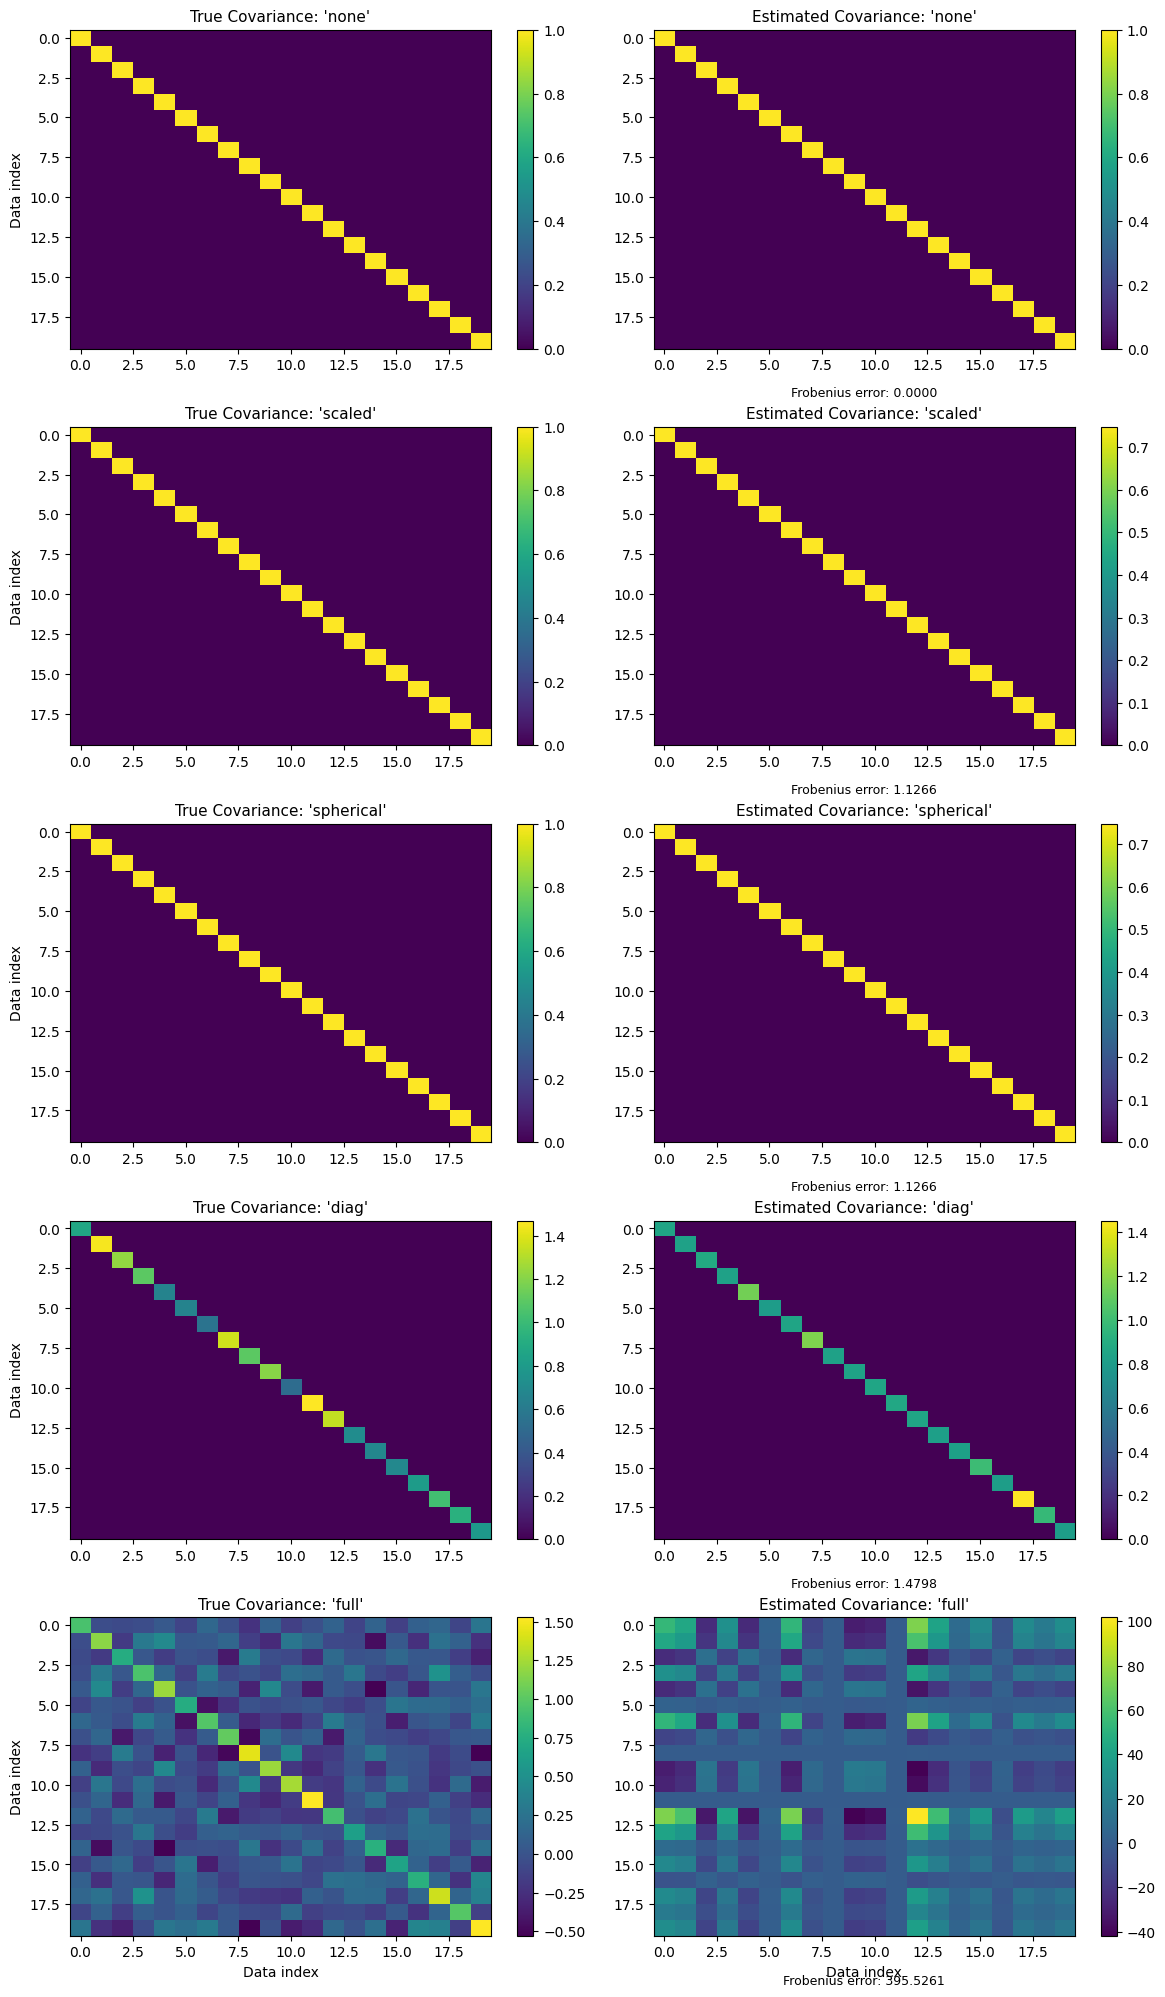


Covariance Matrix Comparison:
Case 'none':
  Frobenius norm error: 0.000000
  Relative error:       0.000000

Case 'scaled':
  Frobenius norm error: 1.126641
  Relative error:       0.251925

Case 'spherical':
  Frobenius norm error: 1.126641
  Relative error:       0.251925

Case 'diag':
  Frobenius norm error: 1.479772
  Relative error:       0.329714

Case 'full':
  Frobenius norm error: 395.526073
  Relative error:       64.166208



In [36]:
# Get all estimated covariances
Cd_ml_none = lik_none.get_ml_cov(result_rl_none.model)
Cd_ml_scaled = lik_scaled.get_ml_cov(result_rl_scaled.model)
Cd_ml_spherical = lik_spherical.get_ml_cov(result_rl_spherical.model)
Cd_ml_diag = lik_diag.get_ml_cov(result_rl_diag.model)
Cd_ml_full = lik_full.get_ml_cov(result_rl_full.model)

# Plot comparison: True vs Estimated covariance matrices
fig, axes = plt.subplots(5, 2, figsize=(12, 20))

covariances = [
    ('none', Cd_true_none, Cd_ml_none),
    ('scaled', Cd_true_spherical, Cd_ml_scaled),  # True is spherical
    ('spherical', Cd_true_spherical, Cd_ml_spherical),
    ('diag', Cd_true_diag, Cd_ml_diag),
    ('full', Cd_true_full, Cd_ml_full),
]

for idx, (case_name, Cd_true, Cd_ml) in enumerate(covariances):
    # True covariance
    im0 = axes[idx, 0].imshow(Cd_true, cmap='viridis', aspect='auto')
    axes[idx, 0].set_title(f"True Covariance: '{case_name}'", fontsize=11)
    axes[idx, 0].set_ylabel("Data index")
    if idx == 4:
        axes[idx, 0].set_xlabel("Data index")
    plt.colorbar(im0, ax=axes[idx, 0])
    
    # Estimated covariance
    im1 = axes[idx, 1].imshow(Cd_ml, cmap='viridis', aspect='auto')
    axes[idx, 1].set_title(f"Estimated Covariance: '{case_name}'", fontsize=11)
    if idx == 4:
        axes[idx, 1].set_xlabel("Data index")
    plt.colorbar(im1, ax=axes[idx, 1])
    
    # Compute Frobenius norm of difference
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    axes[idx, 1].text(0.5, -0.15, f'Frobenius error: {frob_error:.4f}', 
                      transform=axes[idx, 1].transAxes, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print quantitative comparison
print("\nCovariance Matrix Comparison:")
print("="*60)
for case_name, Cd_true, Cd_ml in covariances:
    frob_error = np.linalg.norm(Cd_ml - Cd_true, 'fro')
    rel_error = frob_error / np.linalg.norm(Cd_true, 'fro')
    print(f"Case '{case_name}':")
    print(f"  Frobenius norm error: {frob_error:.6f}")
    print(f"  Relative error:       {rel_error:.6f}")
    print()

#### Summary of ReducedLikelihood Cases

In this section, we explored five different covariance assumptions using CoFI's `ReducedLikelihood` class with **known covariance matrices** for assessment:

1. **'none'**: Standard Gaussian likelihood with fixed known covariance (Cd = σ²I)
   - We provided the exact true covariance matrix
   - ML covariance should exactly match the input

2. **'scaled'**: Scaled reference covariance (Cd = a × Cd_ref)
   - We provided an identity reference matrix
   - The method estimates the scale factor 'a'
   - True scale should be σ² ≈ 1.0

3. **'spherical'**: Spherical covariance (Cd = s × I)
   - No reference covariance needed
   - The method estimates scalar variance 's'
   - True covariance is σ²I

4. **'diag'**: Diagonal covariance with different variances
   - We defined a true diagonal covariance with varying elements
   - The method estimates individual diagonal elements
   - Allows assessment of how well it recovers varying variances

5. **'full'**: Full covariance matrix estimation
   - We defined a true full positive-definite covariance matrix
   - Most flexible but can be unstable
   - Allows assessment of full covariance structure recovery

**Assessment Metrics:**
- **Model parameter errors**: L2 norm between estimated and true parameters
- **Covariance Frobenius error**: ||Cd_estimated - Cd_true||_F
- **Relative covariance error**: Frobenius error normalized by true covariance norm
- **Visual comparison**: Side-by-side heatmaps of true vs estimated covariances

**Key Observations:**
- Cases with known/fixed covariances ('none') should give exact matches
- Cases estimating fewer parameters ('spherical', 'scaled') are more stable
- Cases estimating more parameters ('diag', 'full') allow more flexibility but may have higher estimation error
- The visualization helps identify systematic biases or patterns in covariance estimation

#### Adding Regularization to ReducedLikelihood

Now let's see how to add regularization when using `ReducedLikelihood`. We'll use `QuadraticReg` with damping regularization.

Success: True
Estimated model (with regularization): [-0.93531902 -1.55566472 -0.36601517  0.05354874]
Estimated model (no regularization):   [-5.71964359 -5.10903808  1.82553662  0.97472374]
True model:                            [-6 -5  2  1]
Error with reg (L2):    6.633870
Error without reg (L2): 0.348662


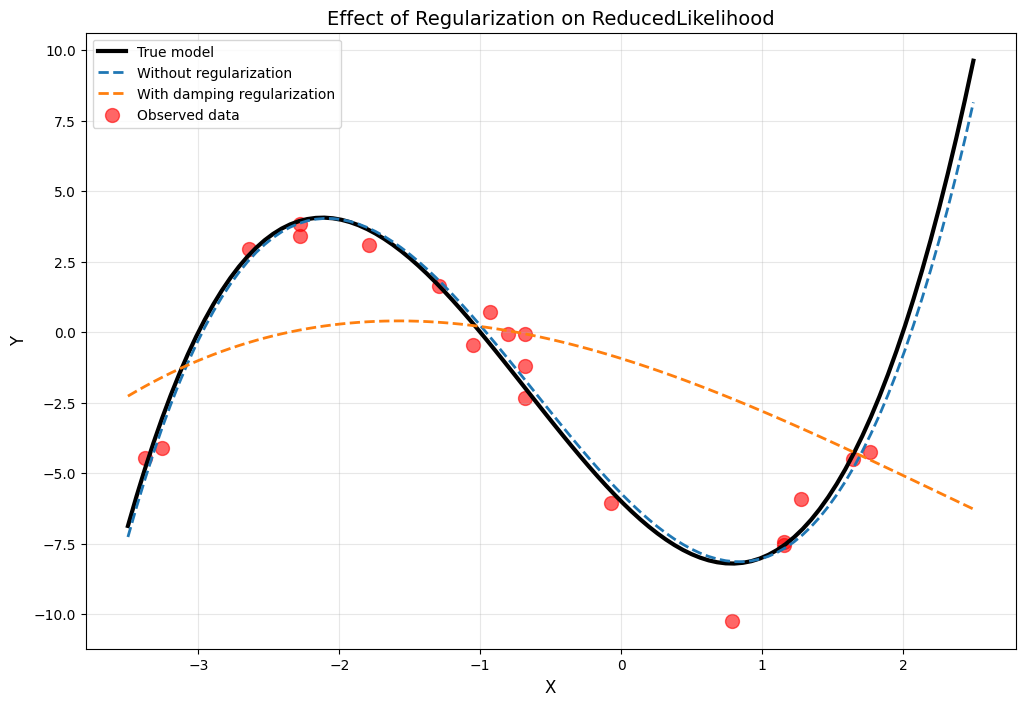

In [37]:
# Create a regularization object with damping
n_dims = 4
my_reg_example = QuadraticReg(
    weighting_matrix='damping',
    model_shape=(n_dims,)
)

# Create ReducedLikelihood (note: it does NOT have a reg parameter)
lik_spherical_for_reg = ReducedLikelihood(
    data=y_observed,
    forward_func=forward_func,
    G=basis_func(x),
    case='spherical'
)

# Define inverse problem WITH REGULARIZATION
# You must manually combine likelihood and regularization in the functions:
inv_problem_rl_reg = BaseProblem()
inv_problem_rl_reg.name = "Polynomial Regression - ReducedLikelihood with Regularization"

# Combine: objective = -log_likelihood + regularization
inv_problem_rl_reg.set_objective(lambda m: -lik_spherical_for_reg.log_likelihood(m) + my_reg_example(m))
inv_problem_rl_reg.set_gradient(lambda m: -lik_spherical_for_reg.gradient(m) + my_reg_example.gradient(m))
inv_problem_rl_reg.set_hessian(lambda m: -lik_spherical_for_reg.hessian(m) + my_reg_example.hessian(m))
inv_problem_rl_reg.set_initial_model(np.zeros(4))

# Set up inversion
inv_options_rl_reg = InversionOptions()
inv_options_rl_reg.set_tool("scipy.optimize.minimize")
inv_options_rl_reg.set_params(method="Newton-CG")

# Run inversion
inv_rl_reg = Inversion(inv_problem_rl_reg, inv_options_rl_reg)
result_rl_reg = inv_rl_reg.run()

print(f"Success: {result_rl_reg.success}")
print(f"Estimated model (with regularization): {result_rl_reg.model}")
print(f"Estimated model (no regularization):   {result_rl_spherical.model}")
print(f"True model:                            {_m_true}")
print(f"Error with reg (L2):    {np.linalg.norm(result_rl_reg.model - _m_true):.6f}")
print(f"Error without reg (L2): {np.linalg.norm(result_rl_spherical.model - _m_true):.6f}")

# Plot comparison
_x_plot = np.linspace(-3.5, 2.5, 100)
_G_plot = basis_func(_x_plot)

plt.figure(figsize=(12, 8))
plt.plot(_x_plot, _G_plot @ _m_true, 'k-', linewidth=3, label='True model')
plt.plot(_x_plot, _G_plot @ result_rl_spherical.model, '--', linewidth=2, 
         label="Without regularization")
plt.plot(_x_plot, _G_plot @ result_rl_reg.model, '--', linewidth=2, 
         label="With damping regularization")
plt.scatter(x, y_observed, color='red', s=100, alpha=0.6, label='Observed data')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Effect of Regularization on ReducedLikelihood', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

---
## 4. A Well-Posed Problem for 'diag' and 'full' Cases

The polynomial regression problem above is ill-suited for the 'diag' and 'full' cases because:
- Only 20 data points to estimate 20+ covariance parameters
- Single realization provides insufficient information

Here we demonstrate a problem that **satisfies the mathematical requirements**:

### Seismic Tomography (Linear)

Consider a simple tomography problem with ray paths through a layered medium:

$$d_i = \sum_{j=1}^{M} G_{ij} m_j + \epsilon_i$$

where:
- $d_i$ = travel time for ray $i$
- $G_{ij}$ = path length of ray $i$ through layer $j$
- $m_j$ = slowness of layer $j$ (unknown)
- $\epsilon_i \sim \mathcal{N}(0, \sigma_i^2)$ = noise with **ray-dependent variance**

### Why This Works

| Case | Requirement | This Problem |
|------|-------------|--------------|
| **'diag'** | Sufficient data for n variances | 100 rays, 5 model params → 95 DOF |
| **'full'** | Correlation structure | Similar ray paths have correlated errors |

In [38]:
# Generate synthetic seismic network data
# Using a LINEAR problem: estimating slowness perturbations in a tomography-like setup
np.random.seed(42)

# Network setup: 100 ray paths through a medium
n_rays = 100
n_model_params = 5  # 5 slowness parameters (simple 1D model)

# Design matrix: each ray samples the model differently
# G[i,j] = path length of ray i through cell j
G_seismic = np.random.uniform(0.5, 2.0, (n_rays, n_model_params))

# True model: slowness perturbations
m_true_seismic = np.array([0.1, -0.05, 0.15, -0.1, 0.08])

# Forward function (linear)
def forward_seismic(m):
    return G_seismic @ m

# Generate heteroscedastic noise (different variance per ray)
# Variance depends on ray path length (longer rays = more noise)
ray_lengths = np.sum(G_seismic, axis=1)
true_variances = 0.01 + 0.02 * (ray_lengths / ray_lengths.max())**2  # variance range
true_stds = np.sqrt(true_variances)
Cd_true_diag_seismic = np.diag(true_variances)

# Generate data with heteroscedastic noise
noise_diag_seismic = np.random.randn(n_rays) * true_stds
d_obs_diag = forward_seismic(m_true_seismic) + noise_diag_seismic

# Generate spatially correlated noise for 'full' case
# Rays with similar paths have correlated errors
correlation_length = 0.3
Cd_true_full_seismic = np.zeros((n_rays, n_rays))
for i in range(n_rays):
    for j in range(n_rays):
        # Correlation based on similarity of ray paths
        path_similarity = np.exp(-np.linalg.norm(G_seismic[i] - G_seismic[j]) / correlation_length)
        Cd_true_full_seismic[i, j] = 0.02 * path_similarity
Cd_true_full_seismic += 0.01 * np.eye(n_rays)  # add diagonal for stability

noise_full_seismic = np.random.multivariate_normal(np.zeros(n_rays), Cd_true_full_seismic)
d_obs_full = forward_seismic(m_true_seismic) + noise_full_seismic

print(f"Problem setup: {n_rays} rays, {n_model_params} model parameters")
print(f"True model: {m_true_seismic}")
print(f"Variance range (diag): [{true_variances.min():.4f}, {true_variances.max():.4f}]")
print(f"Data range: [{d_obs_diag.min():.3f}, {d_obs_diag.max():.3f}]")

Problem setup: 100 rays, 5 model parameters
True model: [ 0.1  -0.05  0.15 -0.1   0.08]
Variance range (diag): [0.0140, 0.0300]
Data range: [-0.229, 0.722]


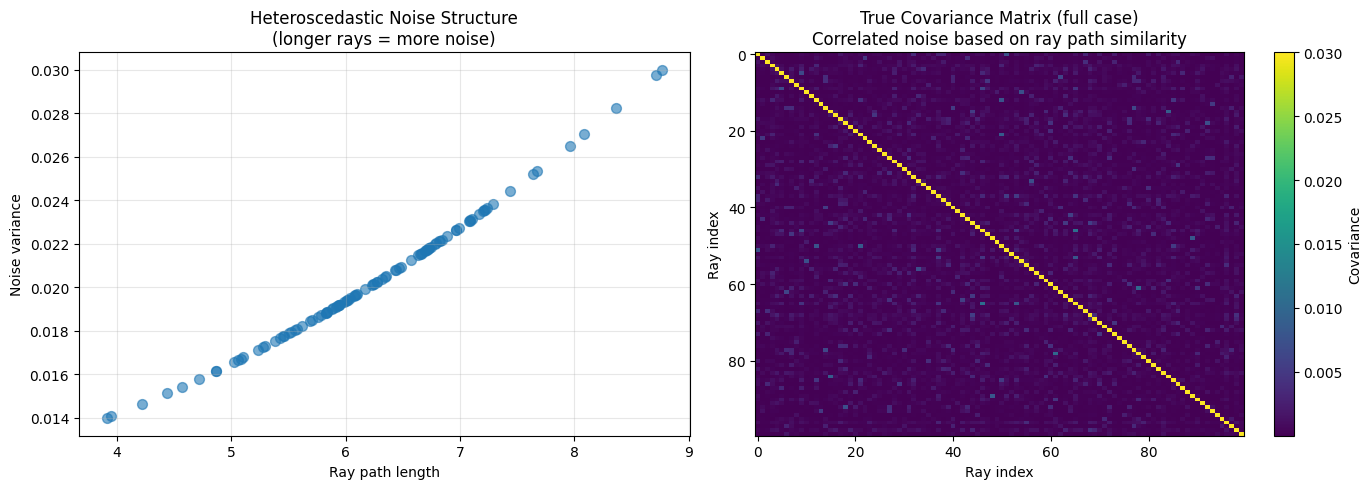

In [39]:
# Visualize the problem setup
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Variance vs ray path length
axes[0].scatter(ray_lengths, true_variances, alpha=0.6, s=50)
axes[0].set_xlabel('Ray path length')
axes[0].set_ylabel('Noise variance')
axes[0].set_title('Heteroscedastic Noise Structure\n(longer rays = more noise)')
axes[0].grid(alpha=0.3)

# Right: True covariance matrix for 'full' case
im = axes[1].imshow(Cd_true_full_seismic, cmap='viridis', aspect='auto')
axes[1].set_xlabel('Ray index')
axes[1].set_ylabel('Ray index')
axes[1].set_title('True Covariance Matrix (full case)\nCorrelated noise based on ray path similarity')
plt.colorbar(im, ax=axes[1], label='Covariance')

plt.tight_layout()
plt.show()

### 'diag' Case: Heteroscedastic Noise

With 100 rays and only 5 model parameters, the 'diag' case is now **well-posed**:
- We estimate 100 variance parameters from 100 data points
- But we only have 5 model unknowns, leaving 95 degrees of freedom for variance estimation

The reduced log-likelihood becomes:
$$\log p(\mathbf{d}|\mathbf{m}) = -\sum_{i=1}^{100} \log|r_i|$$

where $r_i = d_i - (\mathbf{G}\mathbf{m})_i$ is the residual for ray $i$.

In [40]:
# Create ReducedLikelihood with case='diag' for tomography problem
lik_diag_seismic = ReducedLikelihood(
    data=d_obs_diag,
    forward_func=forward_seismic,
    G=G_seismic,
    case='diag'
)

# Use regularization to stabilize the ill-conditioned Hessian
reg_seismic = 1.0 * QuadraticReg(weighting_matrix='damping', model_shape=(n_model_params,))

# Get a good initial guess using least squares (ignoring covariance structure)
m_init = np.linalg.lstsq(G_seismic, d_obs_diag, rcond=None)[0]
print(f"Initial guess (least squares): {m_init}")

# Define inverse problem - only set objective and gradient (BFGS doesn't use Hessian)
inv_problem_diag_seismic = BaseProblem()
inv_problem_diag_seismic.set_objective(lambda m: -lik_diag_seismic.log_likelihood(m) + reg_seismic(m))
inv_problem_diag_seismic.set_gradient(lambda m: -lik_diag_seismic.gradient(m) + reg_seismic.gradient(m))
inv_problem_diag_seismic.set_initial_model(m_init)

# Run inversion with L-BFGS-B (robust quasi-Newton method)
# Use relaxed tolerance since 'diag' case has numerical challenges near zero residuals
inv_options_seismic = InversionOptions()
inv_options_seismic.set_tool("scipy.optimize.minimize")
inv_options_seismic.set_params(method="L-BFGS-B", options={"maxiter": 1000, "gtol": 1e-6, "ftol": 1e-9})

inv_diag_seismic = Inversion(inv_problem_diag_seismic, inv_options_seismic)
result_diag_seismic = inv_diag_seismic.run()

print(f"\nSuccess: {result_diag_seismic.success}")
print(f"Estimated model: {result_diag_seismic.model}")
print(f"True model:      {m_true_seismic}")
print(f"Model error (L2): {np.linalg.norm(result_diag_seismic.model - m_true_seismic):.6f}")

# Get estimated covariance
Cd_est_diag_seismic = lik_diag_seismic.get_ml_cov(result_diag_seismic.model)
est_variances = np.diag(Cd_est_diag_seismic)

Initial guess (least squares): [ 0.08569946 -0.07877398  0.20491756 -0.09435954  0.05970996]

Success: True
Estimated model: [ 0.08079247 -0.06859291  0.19144187 -0.08353833  0.05554633]
True model:      [ 0.1  -0.05  0.15 -0.1   0.08]
Model error (L2): 0.057455


### 'full' Case: Spatially Correlated Noise

For spatially correlated noise, the 'full' case estimates:
$$\hat{C}_d = \mathbf{r}\mathbf{r}^T$$

This produces a **rank-1** covariance estimate from a single realization. While this won't perfectly recover the true covariance, it captures the **correlation structure** when the spatial pattern is strong.

In [41]:
# Create ReducedLikelihood with case='full' for tomography problem
lik_full_seismic = ReducedLikelihood(
    data=d_obs_full,
    forward_func=forward_seismic,
    G=G_seismic,
    case='full'
)

# Get initial guess using least squares
m_init_full = np.linalg.lstsq(G_seismic, d_obs_full, rcond=None)[0]

# Define inverse problem - only set objective and gradient (no Hessian for L-BFGS-B)
inv_problem_full_seismic = BaseProblem()
inv_problem_full_seismic.set_objective(lambda m: -lik_full_seismic.log_likelihood(m) + reg_seismic(m))
inv_problem_full_seismic.set_gradient(lambda m: -lik_full_seismic.gradient(m) + reg_seismic.gradient(m))
inv_problem_full_seismic.set_initial_model(m_init_full)

# Create fresh InversionOptions for 'full' case
inv_options_full_seismic = InversionOptions()
inv_options_full_seismic.set_tool("scipy.optimize.minimize")
inv_options_full_seismic.set_params(method="L-BFGS-B", options={"maxiter": 500, "gtol": 1e-8})

# Run inversion
inv_full_seismic = Inversion(inv_problem_full_seismic, inv_options_full_seismic)
result_full_seismic = inv_full_seismic.run()

print(f"Success: {result_full_seismic.success}")
print(f"Estimated model: {result_full_seismic.model}")
print(f"True model:      {m_true_seismic}")
print(f"Model error (L2): {np.linalg.norm(result_full_seismic.model - m_true_seismic):.6f}")

# Get estimated covariance
Cd_est_full_seismic = lik_full_seismic.get_ml_cov(result_full_seismic.model)

Success: True
Estimated model: [ 0.12239528 -0.07380657  0.20878597 -0.07268761  0.00191784]
True model:      [ 0.1  -0.05  0.15 -0.1   0.08]
Model error (L2): 0.106616


### Results Comparison

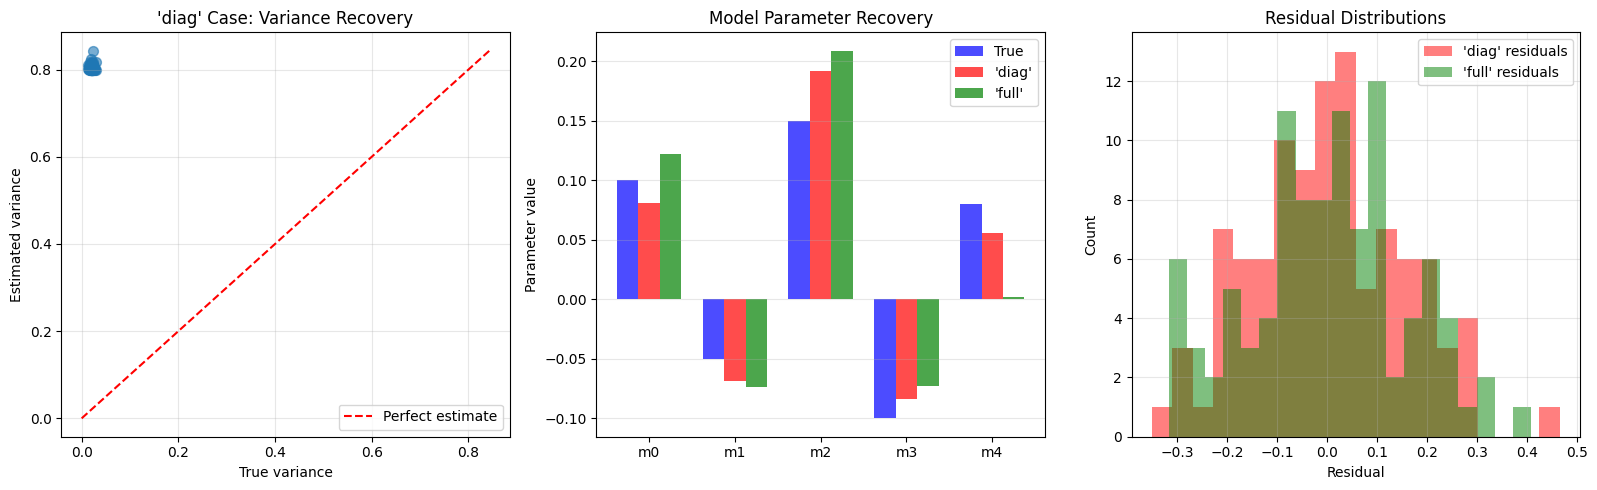

In [42]:
# Visualization: Compare results
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Estimated vs True variances (diag case)
axes[0].scatter(true_variances, est_variances, alpha=0.6, s=50)
max_var = max(true_variances.max(), est_variances.max())
axes[0].plot([0, max_var], [0, max_var], 'r--', label='Perfect estimate')
axes[0].set_xlabel('True variance')
axes[0].set_ylabel('Estimated variance')
axes[0].set_title("'diag' Case: Variance Recovery")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Model parameter comparison
params = [f'm{i}' for i in range(n_model_params)]
x_pos = np.arange(len(params))
width = 0.25

bars1 = axes[1].bar(x_pos - width, m_true_seismic, width, label='True', color='blue', alpha=0.7)
bars2 = axes[1].bar(x_pos, result_diag_seismic.model, width, label="'diag'", color='red', alpha=0.7)
bars3 = axes[1].bar(x_pos + width, result_full_seismic.model, width, label="'full'", color='green', alpha=0.7)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(params)
axes[1].set_ylabel('Parameter value')
axes[1].set_title('Model Parameter Recovery')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

# 3. Residuals comparison
residuals_diag = d_obs_diag - forward_seismic(result_diag_seismic.model)
residuals_full = d_obs_full - forward_seismic(result_full_seismic.model)
axes[2].hist(residuals_diag, bins=20, alpha=0.5, label="'diag' residuals", color='red')
axes[2].hist(residuals_full, bins=20, alpha=0.5, label="'full' residuals", color='green')
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Count')
axes[2].set_title('Residual Distributions')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

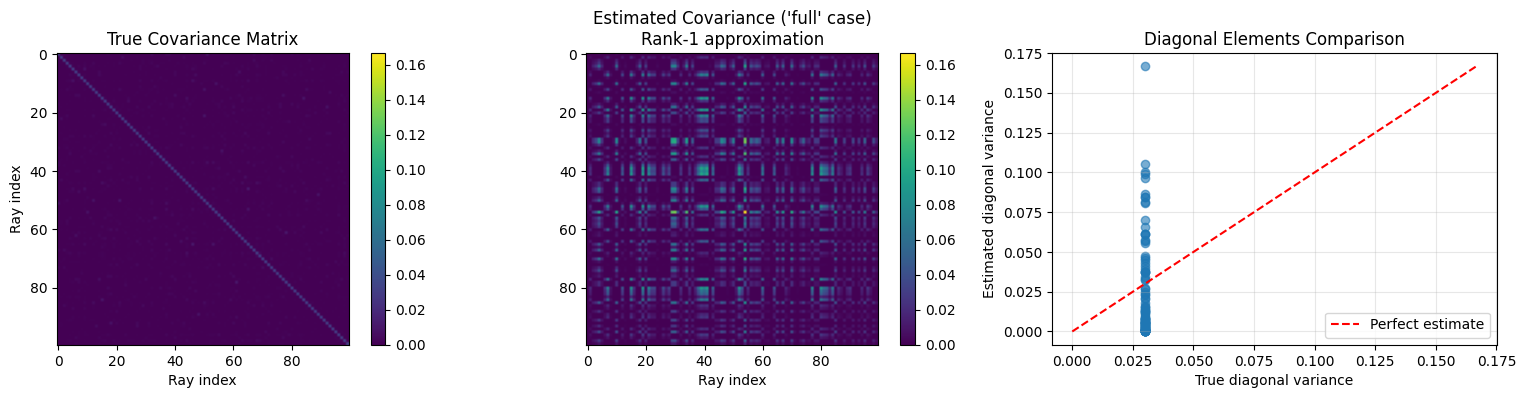


SUMMARY: Well-Posed Problem for 'diag' and 'full' Cases

Problem: 100 rays, 5 model parameters
Degrees of freedom for covariance: 95

'diag' case:
  Model error (L2): 0.057455
  Variance correlation: 0.1233

'full' case:
  Model error (L2): 0.106616
  Covariance Frobenius error: 2.4648
  Estimated covariance rank: 1


In [43]:
# Visualization: Compare covariance matrices for 'full' case
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. True covariance matrix
vmax = max(Cd_true_full_seismic.max(), np.abs(Cd_est_full_seismic).max())
im1 = axes[0].imshow(Cd_true_full_seismic, cmap='viridis', vmin=0, vmax=vmax)
axes[0].set_title('True Covariance Matrix')
axes[0].set_xlabel('Ray index')
axes[0].set_ylabel('Ray index')
plt.colorbar(im1, ax=axes[0])

# 2. Estimated covariance matrix (rank-1)
im2 = axes[1].imshow(Cd_est_full_seismic, cmap='viridis', vmin=0, vmax=vmax)
axes[1].set_title("Estimated Covariance ('full' case)\nRank-1 approximation")
axes[1].set_xlabel('Ray index')
plt.colorbar(im2, ax=axes[1])

# 3. Diagonal comparison
axes[2].scatter(np.diag(Cd_true_full_seismic), np.diag(Cd_est_full_seismic), alpha=0.6)
max_diag = max(np.diag(Cd_true_full_seismic).max(), np.diag(Cd_est_full_seismic).max())
axes[2].plot([0, max_diag], [0, max_diag], 'r--', label='Perfect estimate')
axes[2].set_xlabel('True diagonal variance')
axes[2].set_ylabel('Estimated diagonal variance')
axes[2].set_title('Diagonal Elements Comparison')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY: Well-Posed Problem for 'diag' and 'full' Cases")
print("="*60)

print(f"\nProblem: {n_rays} rays, {n_model_params} model parameters")
print(f"Degrees of freedom for covariance: {n_rays - n_model_params}")

print(f"\n'diag' case:")
print(f"  Model error (L2): {np.linalg.norm(result_diag_seismic.model - m_true_seismic):.6f}")
print(f"  Variance correlation: {np.corrcoef(true_variances, est_variances)[0,1]:.4f}")

print(f"\n'full' case:")
print(f"  Model error (L2): {np.linalg.norm(result_full_seismic.model - m_true_seismic):.6f}")
print(f"  Covariance Frobenius error: {np.linalg.norm(Cd_est_full_seismic - Cd_true_full_seismic, 'fro'):.4f}")
print(f"  Estimated covariance rank: {np.linalg.matrix_rank(Cd_est_full_seismic)}")

In [44]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "pandas"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.10+31.gd8a24f3.dirty
numpy 2.2.6
scipy 1.15.3
matplotlib 3.10.7
pandas 2.3.3
